# How to simulate quantum dynamics subject to noise
**Simulate the dynamics of closed quantum systems in the presence of Non-Markovian noise**

Boulder Opal enables you to simulate the dynamics of quantum systems that are affected by various noise processes. Such simulations can provide useful insights into the expected real-world performance of candidate control solutions. In this notebook we show how to use Boulder Opal to perform simulations of systems affected by different types of noise using graphs.

**Note** This approach is preferable when a simulation becomes part of a larger computation where flexibility is prioritized. For instance, simulation of noisy quantum-system dynamics in the presence of multiple control signals, each distorted by a transmission line.

## Summary workflow
The simulation of quantum dynamics subject to Non-Markovian (colored) noise is used to provide insights into the time-domain evolution of a noise process characterized by a power spectral density with strong low-frequency content.  

### 1. Create noise power spectrum
An arbitrary frequency-domain representation of a noise power spectrum may simply be created using Python commands.

### 2. Link sampled noise trajectories to a graph node
A simulation graph can be built as explained in the [How to simulate quantum dynamics for noiseless systems using graphs](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-simulate-quantum-dynamics-for-noiseless-systems-using-graphs) user guide. To include noise in the simulation you only need to add a term corresponding to the noise Hamiltonian to this graph.

Given the power-spectral density defined in step 1, you can create random noise trajectories in the time domain with average characteristics reflected by the power spectrum. You can generate batches of noise trajectories using the `graph.random.colored_noise_stf_signal` graph operation. This node creates a batch of continuous noise trajectories from the power density of the pink noise. These trajectories can then be discretized with a user-defined number of equally spaced points between the start and the end of the operation evolution. 

From these batches of noise, you can create a batch of noise Hamiltonians where each Hamiltonian of the batch represents a different realization of the noise variable. The batch of noise Hamiltonians is then added to the (noise-free) system Hamiltonian to create a batch of total Hamiltonians. Boulder Opal automatically reconciles differing time segmentation while summing over Hamiltonian terms.

Next create a unitary time-evolution operator from the total Hamiltonian via `graph.time_evolution_operators_pwc` and apply it to evolve the initial state into a final state.

### 3. Execute the graph
Once the overall graph is created it may be executed as usual via `boulderopal.execute_graph`.

## Example: Non-Markovian-noise simulation of a single qubit subject to dephasing noise

In this example we will show how to simulate the dynamics of a single qubit experiencing $1/f$ dephasing noise, driven by a $\pi/2$ [CORPSE](https://docs.q-ctrl.com/open-controls/references/qctrl-open-controls/qctrlopencontrols/new_corpse_control) pulse. The Hamiltonian of the quantum system is:

\begin{align*}
H(t) = & \frac{\Omega(t)}{2} \sigma_- + \frac{\Omega^*(t)}{2} \sigma_+ + \frac{\eta(t)}{2} \sigma_z,
\end{align*}

where $\Omega(t)$ is a time-dependent Rabi rate, $\eta(t)$ is a stochastic dephasing noise process, $\sigma_\pm = (\sigma_x \mp i \sigma_y)/2$, and $\sigma_k$ are the Pauli matrices.

We assume that $\eta(t)$ represents pink noise ($1/f$ noise), as defined below.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qctrlopencontrols as oc
import qctrlvisualizer as qv
import boulderopal as bo

plt.style.use(qv.get_qctrl_style())

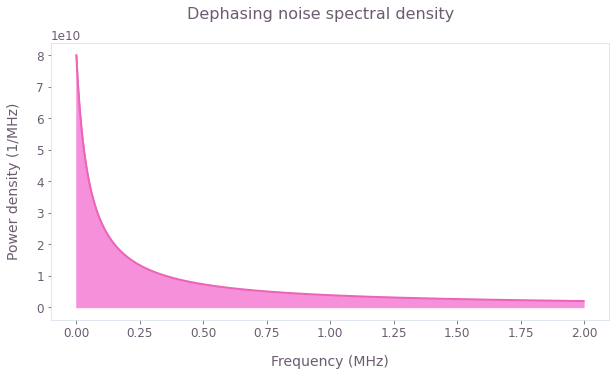

In [2]:
# Define the non-Markovian noise power spectrum.
def pink_spectrum(frequencies, frequency_cutoff):
    return 1 / (frequencies + frequency_cutoff)


frequency_step = 2 * 1e3
frequencies = np.arange(0, 2 * 1e6, frequency_step)

power_densities = 4e9 * pink_spectrum(
    frequencies=frequencies, frequency_cutoff=0.05 * 1e6
)

fig = plt.figure(figsize=(10, 5))
fig.suptitle("Dephasing noise spectral density")
plt.plot(frequencies / 1e6, power_densities * 1e6, color="#EB64B6")
plt.fill_between(frequencies / 1e6, 0, power_densities * 1e6, color="#F790DB")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Power density (1/MHz)")
plt.show()

### Representing the quantum system and noise operator

The drive Hamiltonian is defined as a $\pi/2$ [CORPSE](https://docs.q-ctrl.com/open-controls/references/qctrl-open-controls/qctrlopencontrols/new_corpse_control) pulse, drawn directly from the [Q-CTRL Open Controls](https://github.com/qctrl/open-controls) library.

In [3]:
# Define control parameters.
omega_max = 2 * np.pi * 1e6  # Hz
total_rotation = np.pi / 2

# Import pulse from Q-CTRL Open Controls.
pulse = oc.new_corpse_control(
    rabi_rotation=total_rotation,
    azimuthal_angle=0.0,
    maximum_rabi_rate=omega_max,
    name="CORPSE",
)

In the simulation graph, we define batches of noise trajectories using the `graph.random.colored_noise_stf_signal` node. This node creates a batch of continuous noise trajectories from the power density, which we then discretize to $50$ equally spaced points in the system evolution using `graph.discretize_stf`. From these batches of noise, we will create a batch of noise Hamiltonians where each Hamiltonian of the batch represents a different realization of the noise variable.

We will then create the full Hamiltonian by adding the noise and drive terms together. The noise Hamiltonians were sampled on $50$ time points whereas the CORPSE Hamiltonian contains only $3$ time segments. Boulder Opal automatically reconciles differing time segmentation while summing over Hamiltonian terms. 

In [4]:
# Number of simulations noise trajectories to average over.
trajectory_count = 80

# Define sample times for the output.
sample_times = np.linspace(0, np.sum(pulse.durations), 100)

graph = bo.Graph()

# Define initial state.
initial_state = graph.fock_state(2, 0)[:, None]

# Signal for omega extracted from the imported pulse.
omega_signal = graph.pwc(
    values=pulse.rabi_rates * np.exp(1j * pulse.azimuthal_angles),
    durations=pulse.durations,
    name="omega",
)

# System Hamiltonian.
system_hamiltonian = graph.hermitian_part(omega_signal * graph.pauli_matrix("M"))

# Noise Hamiltonian. Generate random noise trajectories.
noise_stf = graph.random.colored_noise_stf_signal(
    power_spectral_density=power_densities,
    frequency_step=frequency_step,
    batch_shape=(trajectory_count,),
)
noise_pwc = graph.discretize_stf(
    stf=noise_stf, duration=pulse.duration, segment_count=50
)
noise_hamiltonian = noise_pwc * graph.pauli_matrix("Z")

# Combine the system and the noise Hamiltonian to get the total Hamiltonian.
# We can automatically combine a batched and a non-batched term.
hamiltonian = system_hamiltonian + noise_hamiltonian

# Compute the unitaries.
unitaries = graph.time_evolution_operators_pwc(
    hamiltonian=hamiltonian, sample_times=sample_times
)

# Use the unitaries to evolve the initial state.
final_states = unitaries @ initial_state

# Calculate the density matrix from simulated states, ρ = |ψ⟩⟨ψ|.
density_matrices = graph.outer_product(final_states[..., 0], final_states[..., 0])

# Calculate the average density matrices.
average_density_matrices = graph.sum(density_matrices, axis=0) / trajectory_count
average_density_matrices.name = "average_density_matrices"

# Calculate the sigma_x expectation.
sigma_x_expectations = graph.real(
    graph.expectation_value(final_states[..., 0], graph.pauli_matrix("X")),
    name="sigma_x_expectations",
)

### Running the simulation

In the following cell we execute the simulation:

In [5]:
# Run simulation.
simulation_result = bo.execute_graph(
    graph=graph, output_node_names=["average_density_matrices", "sigma_x_expectations"]
)

average_density_matrices = simulation_result["output"]["average_density_matrices"][
    "value"
]
sigma_x_expectations = simulation_result["output"]["sigma_x_expectations"]["value"]

Your task (action_id="1829176") has started.
Your task (action_id="1829176") has completed.


### Extracting the average density matrices

Here we visualize the average evolution of observables.

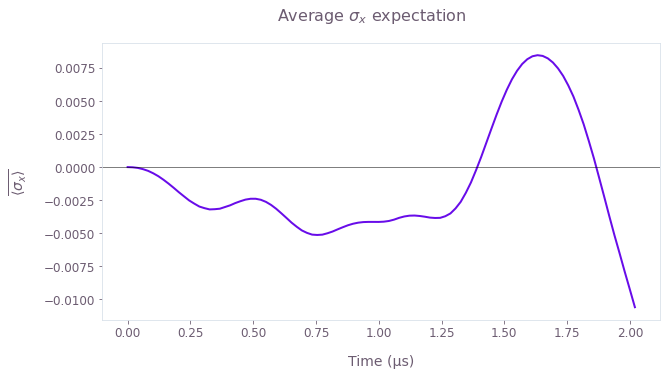

In [6]:
# Plot average sigma_x expectation.
fig = plt.figure(figsize=(10, 5))
plt.suptitle(r"Average $\sigma_x$ expectation")
plt.plot(sample_times * 1e6, np.average(sigma_x_expectations, axis=0))
plt.axhline(y=0.0, c="k", lw=0.5)
plt.xlabel("Time (µs)")
plt.ylabel(r"$\overline{\langle\sigma_x\rangle}$")
plt.show()

### Visualizing the state evolution in the Bloch sphere

Here we visualize the trajectory represented by this evolution in an interactive Bloch sphere using the Q-CTRL Visualizer Python package.

In [7]:
qv.display_bloch_sphere_from_density_matrices(density_matrices=average_density_matrices)

<IPython.core.display.Javascript object>

### Extracting the individual time evolution trajectories

Here we show how to extract the individual random trajectories for the system state under the dephasing noise process employed in the time-domain simulation. For clarity, we only plot the first 10 trajectories.

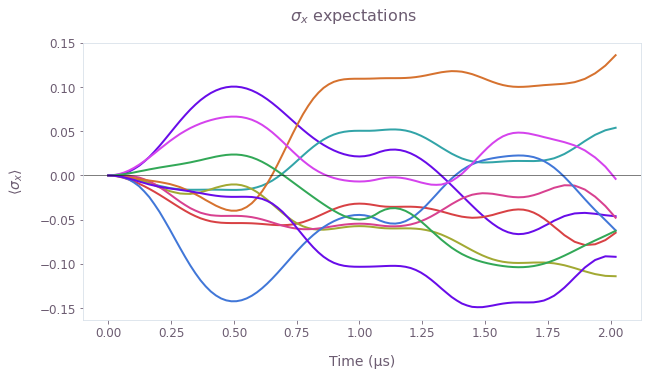

In [8]:
# Plot individual sigma_x expectations.
fig = plt.figure(figsize=(10, 5))
fig.suptitle(r"$\sigma_x$ expectations")
plt.plot(sample_times * 1e6, sigma_x_expectations[0:10].T)
plt.axhline(y=0, c="k", lw=0.5)
plt.xlabel("Time (µs)")
plt.ylabel(r"$\langle\sigma_x\rangle$")
plt.show()